In [ ]:
!pip install pymoo

# Imports and setup
import openai
import numpy as np
import json
from itertools import permutations
import matplotlib.pyplot as plt
from pymoo.problems import get_problem

client = # Put your openai api key

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.2/288.2 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 2.9 MB/s eta 0:00:00
  Created wheel for grapheme: filename=grapheme-0.6.0-py3-none-any.whl size=210082 sha256=419ea6bd24e58878251f856b3fdf125b0ac9a65777bb6e057e85641365f2f30f
  Stored in directory: /root/.cache/pip/wheels/ee/3b/0b/1b865800e916d671a24028d884698674138632a83fdfad4926
Successfully built grapheme


In [ ]:
from pymoo.problems.many.dtlz import DTLZ2
import numpy as np
import scipy

dim = 3

# problem = DTLZ1(n_var=7, n_obj=dim)
problem = DTLZ2(n_var=7, n_obj=dim)

def chebyshev_scalarization(x, w, z_star):
    """
    Evaluate DTLZ1 objectives and compute Chebyshev scalarized value.

    Args:
        x (np.ndarray): Decision variable vector.
        w (np.ndarray): weights for all the objectives (positive weights).
        z_star (np.ndarray): reference (ideal) point for objectives.

    Returns:
        scalarized_value (float), objective values (np.ndarray)
    """
    f = problem.evaluate(x.reshape(1, -1))[0]
    weighted_devs = w * np.abs(f - z_star)
    scalar_val = np.max(weighted_devs)
    return scalar_val, f

# Example weights (positive, can sum to anything)
w = np.abs(np.random.randn(dim))
w = w / np.sum(w)

# Ideal/reference point (DTLZ1 objectives are >= 0)
z_star = np.zeros(dim)

# Test evaluation on random point
x = np.random.rand(problem.n_var)

scalar_val, f = chebyshev_scalarization(x, w, z_star)
print(f"x: {x}")
print(f"w: {w}")
print(f"f: {f}")
print(f"Chebyshev scalarized value: {scalar_val}")

def objective_to_minimize(x, w, z_star):
    val, _ = chebyshev_scalarization(x, w, z_star)
    return val

bounds = [(0, 1)] * problem.n_var  # variable bounds

# Optimize with Chebyshev scalarization
res = scipy.optimize.minimize(objective_to_minimize,
                             x0=0.5*np.ones(problem.n_var),
                             args=(w, z_star),
                             bounds=bounds,
                             method='L-BFGS-B')

opt_x = res.x
opt_val, opt_f = chebyshev_scalarization(opt_x, w, z_star)

print(f"Optimal x found: {opt_x}")
print(f"Objective values at optimum: {opt_f}")
print(f"Chebyshev scalarized value at optimum: {opt_val}")


x: [0.90360542 0.05245758 0.24707835 0.26908758 0.11482507 0.36697422
 0.61582031]
w: [0.24123569 0.41211503 0.34664928]
f: [0.19493743 0.01609933 1.28192289]
Chebyshev scalarized value: 0.4443776515860741
Optimal x found: [0.34467049 0.33761903 0.5        0.5        0.5        0.5
 0.5       ]
Objective values at optimum: [0.73926885 0.43347869 0.51534239]
Chebyshev scalarized value at optimum: 0.1786430833777716


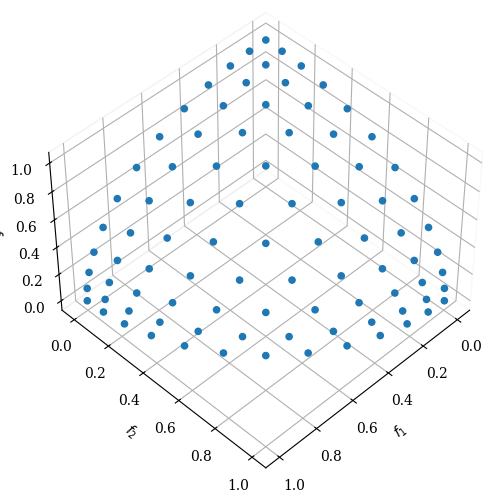

In [ ]:
from pymoo.problems import get_problem
from pymoo.util.plotting import plot
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.visualization.scatter import Scatter

ref_dirs = get_reference_directions("das-dennis", 3, n_partitions=12)

pf = get_problem("dtlz2").pareto_front(ref_dirs)
Scatter(angle=(45,45)).add(pf).show()

In [ ]:
# Design utility function

# Get target weights
# target_weights = np.abs(np.random.rand(dim))
# target_weights = target_weights / np.sum(target_weights)
target_weights = np.array([0.298,0.465,0.237])

# Optimize with Chebyshev scalarization
res = scipy.optimize.minimize(objective_to_minimize,
                             x0=0.5*np.ones(problem.n_var),
                             args=(target_weights, z_star),
                             bounds=bounds,
                             method='L-BFGS-B')
opt_x = res.x
opt_val, f_star = chebyshev_scalarization(opt_x, target_weights, z_star)

# negative utility function given the f1 and f2 values calculated
def user_neg_util(f_star, f_vals):
  return np.linalg.norm(f_star - f_vals, 1)

def get_user_input(f_star, tol, f_vals, prev_score, not_first=True):
  score = user_neg_util(f_star, f_vals)
  # print(f"Current score: {score}")
  # print(f"Previous score: {prev_score}")
  eval = ""
  done = False

  # The results are within the user's range of acceptable results
  if score <= tol:
    # print(f"score: {score}")
    # print(f"f1_star: {f1_star}")
    # print(f"f2_star: {f2_star}")
    # print(f"f1_val: {f1_val}")
    # print(f"f2_val: {f2_val}")
    # print(user_neg_util(f1_star, f2_star, f1_val, f2_val))
    eval += "I am happy with this result!"
    done = True
    return eval, done, score

  # Let the LLM know whether or not they are getting warmer or colder
  if not done and not_first:
    if score < prev_score:
      eval += " These results are better than your last output."
    else:
      eval += " These results are worse than your last output."

  # Let the user know in which direction you would like it to move
  # if not done and f1_val < f1_star:
  #   eval += " I would like for the value of the first objective to increase. Therefore you should increase the weight for the second objective."
  # else:
  #   eval += " I would like for the value of the first objective to decrease. Therefore you should increase the weight for the first objective."

  n = f_star.shape[0]

  for i in range(n):
    # This first if statement is new as of 6/4 morning
    if f_vals[i] <  f_star[i] + tol/3:
      eval += f" I am happy with the value of the {i+1} objective." + "\n"
    elif f_star[i] < f_vals[i]:
      eval += f" I would like for the value of the {i+1} objective to decrease. Therefore you should increase the weight for the {i+1} objective." + "\n"

  return eval, done, score

# function to plot region of acceptability

print(f"Target weights: {target_weights}")
print(f"f_star: {f_star}")
print(np.linalg.norm(f_star))

Target weights: [0.298 0.465 0.237]
f_star: [0.57850098 0.3690921  0.72739785]
1.0


f_star: [0.57850098 0.3690921  0.72739785]


AttributeError: 'Scatter' object has no attribute 'set_title'

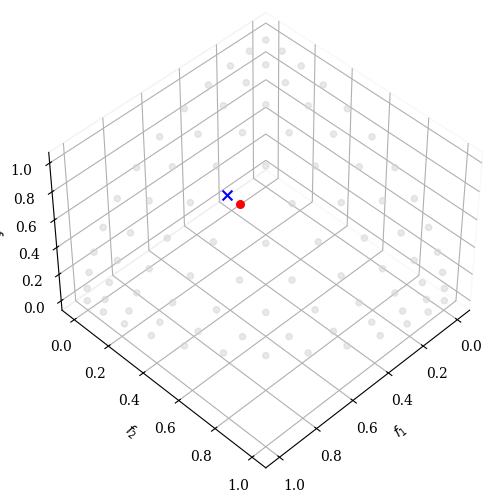

In [ ]:
import numpy as np
from pymoo.visualization.scatter import Scatter
from pymoo.problems import get_problem
from pymoo.util.ref_dirs import get_reference_directions

# Get Pareto front
ref_dirs = get_reference_directions("das-dennis", 3, n_partitions=12)
pf = get_problem("dtlz2").pareto_front(ref_dirs)

# Define tolerance and user optimal point
tol = 0.1
# f_star should be defined from optimization
# For example, if using your previous res:
# f_star = np.array([0.2, 0.3, 0.5])  # example

# Compute L1 distance from each point to f_star
dists = np.linalg.norm(pf - f_star, ord=1, axis=1)

# Get indices of points within tolerance
acceptable_idx = np.where(dists <= tol)[0]
acceptable_points = pf[acceptable_idx]
unacceptable_points = pf[dists > tol]

print(f"f_star: {f_star}")


# Plot with pymoo Scatter
plot = Scatter(angle=(45, 45))
plot.add(unacceptable_points, color="lightgray", alpha=0.5, label="Outside Tolerance")
plot.add(acceptable_points, color="red", s=30, label="Within Tolerance")
plot.add(f_star.reshape(1, -1), color="blue", s=50, marker="x", label="User Optimum")
# Get the matplotlib Axes object and set the title
ax = plot.do()
ax.set_title("Pareto Frontier for DTLZ2 with tol = 0.3")

# Show the plot
plot.show()



In [ ]:
def run_convo_optimization(max_its = 60, tol = 0.3, dim = 3, momentum=False, random=False):

  scores_hist = np.zeros(max_its+1)
  weight_hist = np.zeros((max_its+1,dim))
  opts_hist   = np.zeros((max_its+1,dim))

  # [0.30,0.45,0.25]  We are most interested in optimizing the second objective over the first and second. We slightly prefer optimizing the first objective to optimizing the third
  # objective.
  # w: [0.47437995 0.17795314 0.3476669 ]
  # Initial prompt
  initial_prompt = """
  We are solving a multi-objective Optimization problem with 3 objectives.

  We are most interested in optimizing the second objective over the first and second. We slightly prefer optimizing the first objective to optimizing the third objective.
  Note: When you suggest weights, do not only suggest ones which are even like (0.8,0.1,0.1) but also try different increments like (0.33,0.357, 0.313) and other
  odd combinations. If the user says that you are getting closer to their objective it is usually wiser to change the weights more slowly as you approach their
  desired objective.

  You will choose a pair of weights (minimize_distance, minimize_order_deviation) summing to 1.0, where:
  - `w1` is the weight for the first objective (float between 0 and 1),
  - `w2` is the weight for the second objective (float between 0 and 1).
  - `w3` is the weight for the third objective (float between 0 and 1).

  Please return one weight pair in JSON format:
  {"w1": <float>, "w2": <float>, "w3": <float>}

  Please respond with only the JSON objective, no explanation, comments, or formatting.
  """
  # Note: Was previously using temperature set to 0.7
  def ask_llm_for_weights(conversation_history):
      response = client.chat.completions.create(
          model="gpt-4",
          messages=conversation_history,
          temperature=0.4,
          max_tokens=100
      )
      return response.choices[0].message.content.strip()

  # Simulated initial state
  conversation = [{"role": "system", "content": "You are helping optimize a multi-objective optimization problem."},
                  {"role": "user", "content": initial_prompt}]

  # Ask for the first weights
  response = ask_llm_for_weights(conversation)
  conversation.append({"role": "assistant", "content": response})

  # Parse the response
  weights = json.loads(response)
  w1 = weights["w1"]
  w2 = weights["w2"]
  w3 = weights["w3"]

  weight_hist[0] = [w1, w2, w3]


  # print(f"Weights: w1={w1}, w2={w2}")

  # Run TSP solver (dummy function for illustration)
  bounds = [(0, 1)] * problem.n_var  # variable bounds

  res = scipy.optimize.minimize(objective_to_minimize, x0=0.5*np.ones(problem.n_var), args=(weight_hist[0], z_star),
                bounds=bounds, method='L-BFGS-B')

  opt_x = res.x
  opt_val, opt_f = chebyshev_scalarization(opt_x, weight_hist[0], z_star)
  opts_hist[0] = opt_f



  # Add feedback to LLM and iterate
  feedback_message = f"""
  You chose weights: {weight_hist[0]}.
  Results:
  - Objective 1: {opt_f[0]}
  - Objective 2: {opt_f[1]}
  - Objective 3: {opt_f[2]}
  """

  # Get User feedback
  eval, done, prev_score = get_user_input(f_star, tol, opt_f, 0, not_first=False)
  scores_hist[0] = prev_score

  print(f"Iteration 1")
  print(f"Current objectives: {opt_f}")
  print(f"User True Goal: {f_star}")
  print(f"Score: {prev_score}")
  print("feedback")
  print(feedback_message)

  feedback_message += "User Evaluation: " + eval + "\n"

  feedback_message += "Suggest a new pair of weights to fulfill the user's request. Reminder, you should never repeat the same weights twice so always come up with unique weights different from those you generated before. Respond only with JSON as before."

  conversation.append({"role": "user", "content": feedback_message})

  if done:
    print(f"Finished after {0} iterations.")
    return weight_hist[0], opt_f, weight_hist, opts_hist, scores_hist, 1


  # Repeat interaction
  for i in range(max_its):  # Iterate 3 times
      print(f"Iteration {i+2}")
      response = ask_llm_for_weights(conversation)
      conversation.append({"role": "assistant", "content": response})

      try:
          weights = json.loads(response)


          w1 = weights["w1"]
          w2 = weights["w2"]
          w3 = weights["w3"]

          if random:
            w1 = np.random.rand()
            w2 = np.random.rand()
            w3 = np.random.rand()

            w1 = w1 / (w1 + w2 + w3)
            w2 = w2 / (w1 + w2 + w3)
            w3 = w3 / (w1 + w2 + w3)

          if momentum and i > 1:
            w1 = 0.9 * w1 + 0.1 * weight_hist[i][0]
            w2 = 0.9 * w2 + 0.1 * weight_hist[i][1]
            w3 = 0.9 * w3 + 0.1 * weight_hist[i][2]

          weight_hist[i+1] = [w1, w2, w3]
          bounds = [(0, 1)] * problem.n_var  # variable bounds

          res = scipy.optimize.minimize(objective_to_minimize, x0=0.5*np.ones(problem.n_var), args=(weight_hist[i+1], z_star),
                        bounds=bounds, method='L-BFGS-B')

          opt_x = res.x
          opt_val, opt_f = chebyshev_scalarization(opt_x, weight_hist[i+1], z_star)
          opts_hist[i+1] = opt_f



          # Add feedback to LLM and iterate
          feedback_message = f"""
          You chose weights: {weight_hist[i+1]}.
          Results:
          - Objective 1: {opt_f[0]}
          - Objective 2: {opt_f[1]}
          - Objective 3: {opt_f[2]}
          """

          # Get User feedback
          eval, done, prev_score = get_user_input(f_star, tol, opt_f, prev_score)
          scores_hist[i+1] = prev_score

          feedback_message += "User Evaluation: " + eval + "\n"

          feedback_message += "Suggest a new pair of weights to fulfill the user's request. Reminder, you should never repeat the same weights twice so always come up with unique weights different from those you generated before. Also, remember that you shouldn't only try nice weights like [0.3,0.3,0.4] but try different ones like [0.293,0.611,0.096] Respond only with JSON as before."

          conversation.append({"role": "user", "content": feedback_message})

          print(f"Iteration {i+2}")
          print(f"Current objectives: {opt_f}")
          print(f"User True Goal: {f_star}")
          print(f"Score: {prev_score}")
          print("feedback")
          print(feedback_message)

          if done:
            print(f"Finished after {i+2} iterations.")
            return weight_hist[i+1], opt_f, weight_hist, opts_hist, scores_hist, i+2

      except json.JSONDecodeError:
          print("Error parsing response:", response)
          break

  return weight_hist[-1], opt_f, weight_hist, opts_hist, scores_hist, max_its+1

In [ ]:
w, opt_f, weight_hist, opts_hist, scores_hist, num_its = run_convo_optimization(max_its = 60, tol = 0.1, momentum=False, random=True)

Iteration 1
Current objectives: [0.39303113 0.06711411 0.91707264]
User True Goal: [0.57850098 0.3690921  0.72739785]
Score: 0.6771226283065999
feedback

  You chose weights: [0.35 0.5  0.15].
  Results:
  - Objective 1: 0.3930311337938687
  - Objective 2: 0.06711410586270421
  - Objective 3: 0.9170726387058747
  
Iteration 2
Iteration 2
Current objectives: [3.74939946e-33 6.12323400e-17 1.00000000e+00]
User True Goal: [0.57850098 0.3690921  0.72739785]
Score: 1.220195229257298
feedback

          You chose weights: [0.65002977 0.19154384 0.02345473].
          Results:
          - Objective 1: 3.749399456654644e-33
          - Objective 2: 6.123233995736766e-17
          - Objective 3: 1.0
          User Evaluation:  These results are worse than your last output. I am happy with the value of the 1 objective.
 I am happy with the value of the 2 objective.
 I would like for the value of the 3 objective to decrease. Therefore you should increase the weight for the 3 objective.

Suggest a

BadRequestError: Error code: 400 - {'error': {'message': "This model's maximum context length is 8192 tokens. However, your messages resulted in 8194 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}}

In [ ]:
## function to run test to get average convergence times

def run_test(runs, its, my_tol, mom=False):
  num_its_hist = np.zeros(runs)
  all_scores_hist = np.zeros((runs,its+1))

  # weight_hist[-1], opt_f, weight_hist, opts_hist, scores_hist, max_its+1
  for i in range(runs):
    print(f"Run: {i}")
    _, _, _, _, scores_hist, num_its = run_convo_optimization(max_its = its, tol = my_tol, dim = 3, momentum=mom)

    num_its_hist[i] = num_its
    all_scores_hist[i] = scores_hist

  return num_its_hist, all_scores_hist

Run: 0
Iteration 1
Current objectives: [0.55219249 0.09498012 0.82828873]
User True Goal: [0.57850098 0.3690921  0.72739785]
Score: 0.40131135450293626
feedback

  You chose weights: [0.3 0.5 0.2].
  Results:
  - Objective 1: 0.5521924932465377
  - Objective 2: 0.09498011615171559
  - Objective 3: 0.8282887346438915
  
Iteration 2
Iteration 2
Current objectives: [0.71746166 0.35746697 0.59788472]
User True Goal: [0.57850098 0.3690921  0.72739785]
Score: 0.2800989515172733
feedback

          You chose weights: [0.25 0.45 0.3 ].
          Results:
          - Objective 1: 0.717461658713985
          - Objective 2: 0.3574669706887836
          - Objective 3: 0.5978847155948726
          User Evaluation:  These results are better than your last output. I would like for the value of the 1 objective to decrease. Therefore you should increase the weight for the 1 objective.
 I am happy with the value of the 2 objective.
 I am happy with the value of the 3 objective.

Suggest a new pair of we

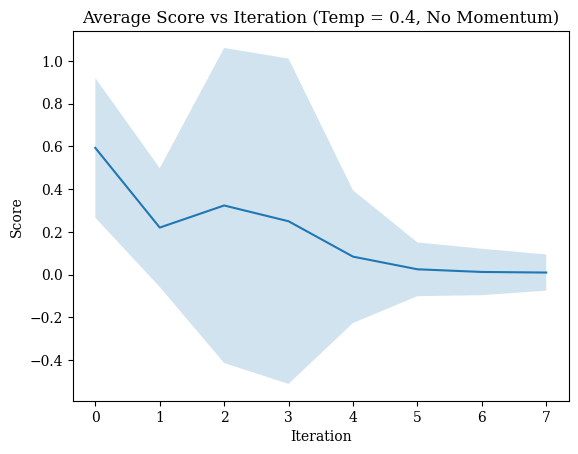

In [ ]:
num_its_hist, all_scores_hist = run_test(runs=20, its=30, my_tol=0.2, mom=False)

print(f"Average Number of Iterations: {np.mean(num_its_hist)}")
print(f"Standard Deviation of Number of Iterations: {np.std(num_its_hist)}")

# Plot average scores vs iteration
avg_scores_hist = np.mean(all_scores_hist, axis=0)
std_scores_hist = np.std(all_scores_hist, axis=0)
max_its = int(np.max(num_its_hist))


plt.plot(avg_scores_hist[:max_its])
plt.fill_between(np.arange(max_its), avg_scores_hist[:max_its]-1.96*std_scores_hist[:max_its], avg_scores_hist[:max_its]+1.96*std_scores_hist[:max_its], alpha=0.2)
plt.xlabel("Iteration")
plt.ylabel("Score")
plt.title("Average Score vs Iteration (Temp = 0.4, No Momentum)")
plt.show()


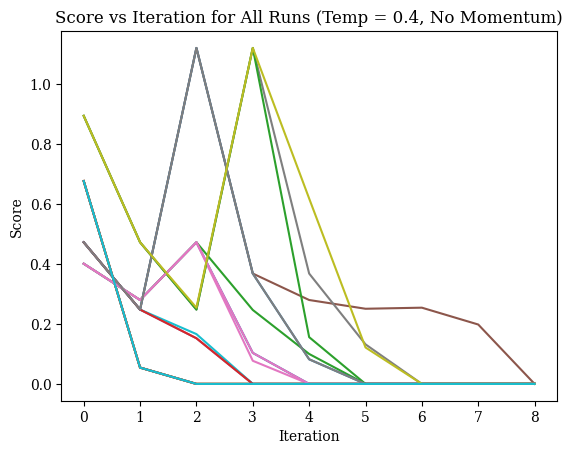

In [ ]:
#Plot all the iterations
for i in range(20):
  plt.plot(all_scores_hist[i,:max_its+1])

plt.xlabel("Iteration")
plt.ylabel("Score")
plt.title(f"Score vs Iteration for All Runs (Temp = 0.4, No Momentum)")
plt.show()

Run: 0
Iteration 1
Current objectives: [0.49273496 0.11693942 0.86228617]
User True Goal: [0.57850098 0.3690921  0.72739785]
Score: 0.4728070167279973
feedback

  You chose weights: [0.35 0.45 0.2 ].
  Results:
  - Objective 1: 0.49273496003395273
  - Objective 2: 0.1169394182335745
  - Objective 3: 0.8622861657382265
  
Iteration 2
Iteration 2
Current objectives: [0.62450776 0.46861116 0.62481488]
User True Goal: [0.57850098 0.3690921  0.72739785]
Score: 0.2481088147523262
feedback

          You chose weights: [0.3 0.4 0.3].
          Results:
          - Objective 1: 0.6245077629513245
          - Objective 2: 0.4686111608185534
          - Objective 3: 0.6248148797602536
          User Evaluation:  These results are better than your last output. I would like for the value of the 1 objective to decrease. Therefore you should increase the weight for the 1 objective.
 I would like for the value of the 2 objective to decrease. Therefore you should increase the weight for the 2 objectiv

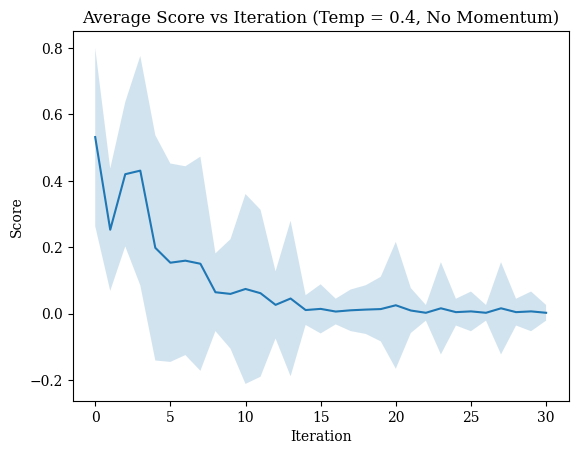

In [ ]:
num_its_hist, all_scores_hist = run_test(runs=20, its=30, my_tol=0.05, mom=False)

print(f"Average Number of Iterations: {np.mean(num_its_hist)}")
print(f"Standard Deviation of Number of Iterations: {np.std(num_its_hist)}")

# Plot average scores vs iteration
avg_scores_hist = np.mean(all_scores_hist, axis=0)
std_scores_hist = np.std(all_scores_hist, axis=0)
max_its = int(np.max(num_its_hist))


plt.plot(avg_scores_hist[:max_its])
plt.fill_between(np.arange(max_its), avg_scores_hist[:max_its]-1.96*std_scores_hist[:max_its], avg_scores_hist[:max_its]+1.96*std_scores_hist[:max_its], alpha=0.2)
plt.xlabel("Iteration")
plt.ylabel("Score")
plt.title("Average Score vs Iteration (Temp = 0.4, No Momentum)")
plt.show()


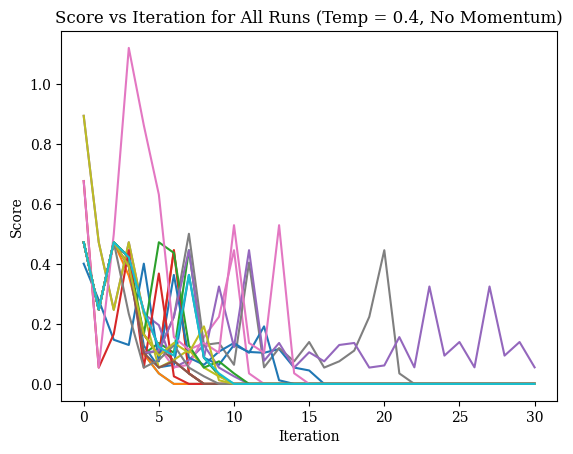

In [ ]:
#Plot all the iterations
for i in range(20):
  plt.plot(all_scores_hist[i,:max_its+1])

plt.xlabel("Iteration")
plt.ylabel("Score")
plt.title(f"Score vs Iteration for All Runs (Temp = 0.4, No Momentum)")
plt.show()